In [1]:
# import sys
# !{sys.executable} -m pip install xlrd

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
today = dt.date.today()
today_str = f'{today.year}_{today.month}_{today.day}'

In [4]:
df = pd.read_excel('./excel/Development Application Tracking Spreadsheet.xlsm',sheet_name = 'Plans in Review')
df['Project'] = df.apply(lambda row: row.Project.upper().replace('  ', ' '), axis=1)
df['ApplicationType'] = df.apply(lambda row: row.Type.upper(), axis=1)
df['Planner'] = df.apply(lambda row: row.Planner.upper(), axis=1)
df['Engineer'] = df.apply(lambda row: row.Engineer.upper(), axis=1)
df['ApplicationSubmission'] = df['Submission Date']
df['CommentsDue'] = df['Comments Due']
df['CommentTimeline'] = df.apply(lambda row: row.CommentsDue - row.ApplicationSubmission, axis = 1)
df['TimeRemaining'] = df.apply(lambda row: row.CommentsDue.date() - today, axis = 1)
df['TimeRemainingInt'] = df.apply(lambda row: row.TimeRemaining.days, axis = 1)
df['PercentTimeRemaining'] = df.apply(lambda row: round(row.TimeRemaining / row.CommentTimeline,2), axis = 1)
df['FullCommentPeriod'] = df.apply(lambda row: (row.CommentsDue - row.ApplicationSubmission).days, axis=1)
df['CommentsDue'] = df.apply(lambda row: dt.date(row.CommentsDue.year, row.CommentsDue.month, row.CommentsDue.day), axis=1)

conditions = [
    (df.TimeRemainingInt < 0),
    (df.TimeRemainingInt <= 7) & (df.TimeRemainingInt >= 0),
    (df.TimeRemainingInt > 7) & (df.TimeRemainingInt <= 14),
    (df.TimeRemainingInt > 14)
]
choices = ['Overdue', '0-7 Days','8-14 Days','> 14 Days']
df['PieTimeline'] = np.select(conditions, choices, default='No')

drop = ['Type', 'Submission Date', 'Comments Due', 'Comments Sent', 'Resubmission Due']
exclude = ['AS-BUILTS', 'BOUNDARY LINE ADJUSTMENT']
keep = [x for x in df.ApplicationType.unique().tolist() if x not in exclude]

df = df.drop(drop, axis = 1)
df = df.loc[df.ApplicationType.isin(keep)]

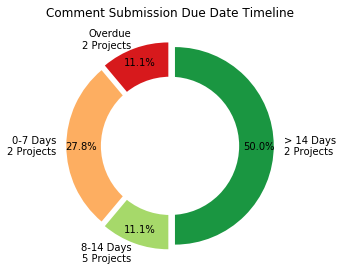

In [5]:
def pie_timeline():
    classes = ['Overdue', '0-7 Days', '8-14 Days', '> 14 Days']
    sizes = [df.loc[df.PieTimeline == x].shape[0] for x in classes]
    labels = [f'Overdue\n{sizes[0]} Projects', f'0-7 Days\n{sizes[0]} Projects', f'8-14 Days\n{sizes[1]} Projects', f'> 14 Days\n{sizes[2]} Projects']
    colors = ['#d7191c','#fdae61','#a6d96a','#1a9641']
    explode = (0.05,0.05,0.05,0.05)

    plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('Comment Submission Due Date Timeline')
    plt.tight_layout()
    
    plt.savefig('./output/drp_pie.png', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype='letter', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    
pie_timeline()

In [6]:
table_df = pd.DataFrame(df[['Project', 'ApplicationType', 'Submission', 'CommentsDue', 'FullCommentPeriod', 'Planner', 'Engineer']], copy=True).sort_values('CommentsDue')

col_labels = ['Project', 'Application Type', 'Submission', 'Comments Due', 'Comment Period', 'Planner', 'Engineer']
cell_text = []
t = []
cell_colors = []
for x in table_df.index.values.tolist():
    t.append(table_df.loc[df.index == x].values.tolist())
colors = ['#d7191c','#fdae61','#a6d96a','#1a9641']

for x in t:
    cell_text.append(x[0])
    time_delta = (x[0][3] - today).days
    if time_delta < 0:
        cell_colors.append('#d7191c')
    elif 0 <= time_delta <= 7:
        cell_colors.append('#fdae61')
    elif 7 < time_delta <= 14:
        cell_colors.append('#a6d96a')
    elif time_delta > 14:
        cell_colors.append('#1a9641')

cell_colors = [[x,x,x,x,x,x,x] for x in cell_colors]

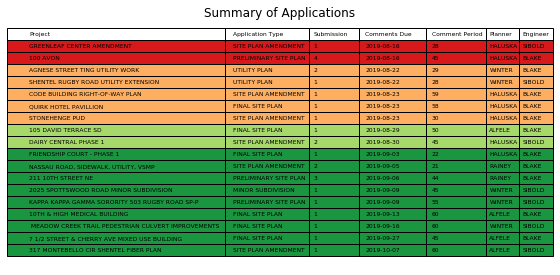

In [8]:
fig, axs = plt.subplots(1,1)
axs.axis('tight')
axs.axis('off')

table = axs.table(
    cellText=cell_text, 
    cellColours= cell_colors, 
    cellLoc='left', 
    colWidths=[0.65, 0.25, 0.15, 0.2, 0.18, 0.1, 0.1], 
    rowLabels=None, 
    rowColours=None, 
    rowLoc='left', 
    colLabels=col_labels, 
    colColours=None, 
    colLoc='left', 
    loc='center', 
    bbox=None, 
    edges='closed')

table.auto_set_font_size(False)
table.set_fontsize(6)
plt.title('Summary of Applications', y = 1.05)

plt.savefig('./output/drp_table.png', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype='letter', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)